## Notebook for fitting cardinal data

In [1]:
#--------------- Packages ---------------#
import os
import sys
import emcee
import fitsio
import Corrfunc
import numpy as np
from classy import Class
import cluster_toolkit as ctk
from astropy.table import Table
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
# from colossus.halo import concentration
from colossus.cosmology import cosmology
from scipy.stats import norm#, multivariate_normal
from colossus.halo import profile_composite, concentration, profile_nfw, profile_einasto

# from cluster_toolkit import miscentering
import numdifftools as nd
import argparse

plt.style.use("CustomizingPlots")
%matplotlib inline

### Cardinal $\Delta\Sigma$

In [2]:
h = 0.7
file_path = r"/bsuhome/tnde/Lensing/data/"

### Load the halos with the DS and Sigma profiles
# halos_ds =  Table(np.load(file_path+"stacked_DS_halo_run.npy", allow_pickle=True))
halos_ds =  Table(np.load(file_path+"stacked_DS_halo_run_updated.npy", allow_pickle=True))
# halos_ds = halos_ds[(halos_ds['Redshift']>=0.2) & (halos_ds['Redshift']<=0.7)]
# halos_ds['Sigma'] = halos_ds['Sigma']*1e12*h
# halos_ds['DeltaSigma'] = halos_ds['DeltaSigma']*1e12*h
print(len(halos_ds))
print(halos_ds.columns)
halos_ds#["DS_mean"]

12
<TableColumns names=('redshift_range','lambda_range','halo_count','Mvir','cvir','Redshift','lambda','rho_mean','DS_mean','sigma_mean','Rvir_mean','rs_mean')>


redshift_range,lambda_range,halo_count,Mvir,cvir,Redshift,lambda,rho_mean,DS_mean,sigma_mean,Rvir_mean,rs_mean
object,object,int64,float32,float64,float64,float32,float64[10],float64[15],float64[15],float64,float64
"[0.2,0.35)","[20,30)",527,14.256152,4.130135888692788,0.2970780420458355,23.48188,2025696608319645.5 .. 1487352332588.9116,64.43214840745591 .. 1.274437015716523,497.15835517196234 .. 8.35248984101689,494.81217160726067,119.80530058633775
"[0.2,0.35)","[30,45)",132,14.481987,4.435882669775707,0.2991529939737227,35.343403,2312471279466939.0 .. 2310000275143.064,96.32637985136489 .. 1.772421015365792,650.8986926054115 .. 8.527792738970128,599.9468688978312,135.2485882878788
"[0.2,0.35)","[45,60)",28,14.567497,4.558644150429514,0.28431276201750233,50.04542,3188113890292132.0 .. 2688336723331.634,105.5925154625651 .. 1.4392630777968907,798.7653612146389 .. 9.450560902437221,510.9361356988438,112.08072374999999
"[0.2,0.35)","[60,∞)",49,14.7768345,6.1549069979391495,0.287592304137053,93.02376,4426192334251622.0 .. 4558483814891.827,136.57019897636766 .. 2.049246675647998,1077.7474059846636 .. 10.28542612487304,559.5391191675183,90.90943524489794
"[0.35, 0.5)","[20,30)",2572,14.036441,3.881283001336679,0.4341746439163812,23.705675,1863615807879386.5 .. 1263605068309.9595,42.26968700905919 .. 1.3104215082671813,472.150735315319 .. 15.771647138720754,147.75350859065824,38.06821315007776
"[0.35, 0.5)","[30,45)",763,14.268896,4.243402019053453,0.435604698768492,35.46561,2299277030074116.5 .. 1810434066745.252,55.74934205294064 .. 1.7685636625056718,639.1339248917003 .. 16.38852312347822,163.84571899021708,38.611877511140236
"[0.35, 0.5)","[45,60)",182,14.446785,3.6487285377430814,0.4352598488887802,51.23738,2967456612316544.5 .. 2786681703336.037,58.10019725079432 .. 2.0657013941383346,774.5068079546207 .. 16.29111423137691,195.93372049542302,53.699177252747255
"[0.35, 0.5)","[60,∞)",165,14.660221,5.0437456067738795,0.4320669261800679,93.32823,4246524971689604.5 .. 4030464417406.323,88.73758999957542 .. 2.378665806691195,1098.775703542985 .. 15.750420021244997,239.0608089934224,47.39747553333333
"[0.5, 0.65)","[20,30)",2844,13.937834,3.4189626495054553,0.5786409757383967,23.575611,2135637771500529.2 .. 1427155847636.7803,42.456759962225036 .. 1.493349387251409,558.5898818699247 .. 21.90914441693969,0.9841689040208741,0.2878559975386779


## Plotting DS data

### Radial bins

In [3]:
Rmin_phys_mpc = 0.0323
Rmax_phys_mpc = 30
nbins_phys_mpc = 15
lnrp_bins_phys_mpc = np.linspace(np.log(Rmin_phys_mpc), np.log(Rmax_phys_mpc), nbins_phys_mpc+1)
rp_bins_phys_mpc = np.exp(lnrp_bins_phys_mpc)
rp_phys_mpc = np.sqrt(rp_bins_phys_mpc[:-1]*rp_bins_phys_mpc[1:])
rp = rp_phys_mpc
rp

array([ 0.04056329,  0.06397266,  0.10089175,  0.15911711,  0.25094477,
        0.39576683,  0.62416676,  0.98437798,  1.55246972,  2.44841136,
        3.86140749,  6.08985404,  9.60435342, 15.14709612, 23.88859625])

## Setting cosmology

In [4]:
# Set cardindal cosmology
## Colossus cosmology
cosmo_params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.047, 'sigma8': 0.82, 'ns': 0.96}
cosmology.addCosmology('cardinal', cosmo_params)
cosmo = cosmology.setCosmology('cardinal')
h = cosmo_params['H0']/100

## Cluster toolkit cosmology
#Start by specifying the cosmology
Omega_b = cosmo_params['Ob0']
Omega_m = cosmo_params['Om0']
Omega_cdm = Omega_m - Omega_b
sigma8 = cosmo_params['sigma8']
h = cosmo_params['H0']/100 # McClintock h value
# A_s = 2.1e-9 #np.exp(3.064)/1e10 NB: ln(1e10*As)=3.064
n_s = cosmo_params['ns']
# z = 0.3

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 1000 #UNITS: 1/Mpc

params = {
         'output':'mPk',
         'h':h,
         'sigma8':sigma8,
         'n_s':n_s,
         'Omega_b':Omega_b,
         'Omega_cdm':Omega_cdm,
         'P_k_max_1/Mpc':k_max,
         'z_max_pk':1.0, #Default value is 10
         'non linear':'halofit'
}

#Initialize the cosmology and compute everything
cosmo_ctk = Class()
cosmo_ctk.set(params)
cosmo_ctk.compute()

## Calibration

In [5]:
def log_likelihood(params, rp, data, cov, z, input_units = "physical"):
    log10_M, c = params
    M = (10**log10_M) #Msun/h #mass has no h, so we added the h here.

    a = 1/(1+z) # scale factor
    Rproj = np.logspace(-2, 2.4, num=1000, base=10) #Mpc/h Projected 2D radii. 
    R3d = np.logspace(-2, 3, num=1000, base=10) #Mpc/h comoving. 3D radii.
    
    # McClintock radial bins
    Rmin = 0.0323
    Rmax = 30
    nbins = 15
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z)
    # Rp_mid = (Redges[:-1]+Redges[1:])/2
    # if input_units == "physical":
    #     Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    #     # Redges *= (1+z) #Converted to Mpc/h comoving
    #     # Redges *= h*(1+z) #Converted to Mpc/h comoving
    #     Rp_mid = (Redges[:-1]+Redges[1:])/2
    # else:
    #     Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    #     Rp_mid = (Redges[:-1]+Redges[1:])/2

    """
    Note:
    Minimum Rproj for Sigma(Rproj) must be >= than min(r) of xi(r).
    Maximum Rproj for Sigma(Rproj) must be <= than max(r) of xi(r).
    Thus, the range of values for Rproj must be 
    equal to (or contained in) that of r
    """
    
    #Specify k and z
    # k = np.logspace(-5, 3, num=4000) #Mpc^-1 comoving
    k = np.logspace(-5, np.log10(k_max), num=4000) #Mpc^-1 comoving
    # Power spectrum
    Pnonlin = np.array([cosmo_ctk.pk(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
    Plin = np.array([cosmo_ctk.pk_lin(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
    kh = k/h #h/Mpc comoving
    # k /= h #h/Mpc comoving
    #P(k) are in Mpc^3/h^3 comoving
    #Thus, you will need to convert these to h/Mpc and (Mpc/h)^3 to use in the toolkit.
    Plin *= h**3
    Pnonlin *= h**3

    # NFW profile
    xi_nfw = ctk.xi.xi_nfw_at_r(R3d, M, c, Omega_m, delta=200) #delta=200 by default

    # # Matter-matter correlation function (matter auto-correlation)
    xi_mm = ctk.xi.xi_mm_at_r(R3d, kh, Pnonlin)

    # 2-halo correlation function
    bias_term = ctk.bias.bias_at_M(M, kh, Plin, Omega_m, delta=200) # Here, P must be linear. #delta=200 by default
    xi_2halo = ctk.xi.xi_2halo(bias_term, xi_mm)

    # Halo-matter correlation function
    xi_hm = ctk.xi.xi_hm(xi_nfw, xi_2halo)

    # Sigma (computed from xi_hm)
    Sigma = ctk.deltasigma.Sigma_at_R(Rproj, R3d, xi_hm, M, c, Omega_m, delta=200) #delta=200 by default
    # Sigma = ctk.deltasigma.Sigma_nfw_at_R(Rproj, M, c, Omega_m, delta=200)

    # DeltaSigma (excess surface density)
    DS = ctk.deltasigma.DeltaSigma_at_R(Rproj, Rproj, Sigma, M, c, Omega_m, delta=200) #delta=200 by default
    ave_DS = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS)
    
    if input_units == "physical":
        # model = ave_DS*(1+z)**2 #convert to hMsun/pc^2 physical
        model = ave_DS*h*(1+z)**2#convert to Msun/pc^2 physical
    else:
        model = ave_DS
    
    #################################################
    ## Colossus profile
    # rp_phys = (Rp_mid*1e3)*h #kp/h physical
    rp_phys = (rp*1e3)*h #kp/h physical
    p_nfw = profile_nfw.NFWProfile(M = M, c = c, z = z, mdef = '200m') #cardinal overdensity definition is vir
    # p_nfw = profile_composite.compositeProfile('nfw', outer_names = ['pl'], #outer_names = ['pl'],
    #                                            M = M, c = c, z = z, mdef = '200m', #cardinal overdensity definition is vir
    #                                            norm = 1.0, slope = 1.5, pl_delta_1 = 4.0, pl_s = 1.4)
    # b = bias.haloBias(M, z, '200m')
    # p_nfw = profile_composite.compositeProfile('nfw', outer_names = ['cf'], 
    #                                            M = M, c = c, z = z, mdef = '200m', bias = b) #cardinal overdensity definition is vir
    
    p_einasto = profile_einasto.EinastoProfile(M = M, c = c, z = z, mdef = '200m') #cardinal overdensity definition is vir
    # p_einasto = profile_composite.compositeProfile('einasto', outer_names = ['pl'], #outer_names = ['pl'], 
    #                                            M = M, c = c, z = z, mdef = '200m', #cardinal overdensity definition is vir
    #                                            norm = 1.0, slope = 1.5, pl_delta_1 = 4.0, pl_s = 1.4)
    # p_einasto = profile_composite.compositeProfile('einasto', outer_names = ['cf'], #outer_names = ['pl'], 
    #                                            M = M, c = c, z = z, mdef = '200m', bias = b) #cardinal overdensity definition is vir

    #-------------Calculating Delta Sigma for nfw and einasto profile
    ## nfw
    ds_nfw = p_nfw.deltaSigma(rp_phys)
    ## einasto
    ds_einasto = p_einasto.deltaSigma(rp_phys)
    
    if input_units == "physical":
        ds_theory_nfw = h*ds_nfw*1e-6  # colossus works in physical units; hence, there is no need to do ds_nfw*a**2*1e-6  
        ds_theory_einasto = h*ds_einasto*1e-6  # colossus works in physical units; hence, there is no need to do ds_einasto*a**2*1e-6 
    else:
        ds_theory_nfw = h*ds_nfw*a**2*1e-6  
        ds_theory_einasto = h*ds_einasto*a**2*1e-6  
    ############################################
    
    # covariance
    icov_cut = np.linalg.inv(cov)
    
    # Difference between data and model and the likelihood.
    data_diff = data - model
    # print(len(data))
    # print(len(DS))
    data_likelihood = -0.5*np.dot(data_diff, np.dot(icov_cut, data_diff))
    return data_likelihood, model, ds_theory_nfw, ds_theory_einasto #DS_model#, ave_DS


In [6]:
rp

array([ 0.04056329,  0.06397266,  0.10089175,  0.15911711,  0.25094477,
        0.39576683,  0.62416676,  0.98437798,  1.55246972,  2.44841136,
        3.86140749,  6.08985404,  9.60435342, 15.14709612, 23.88859625])

### Theoretical fits

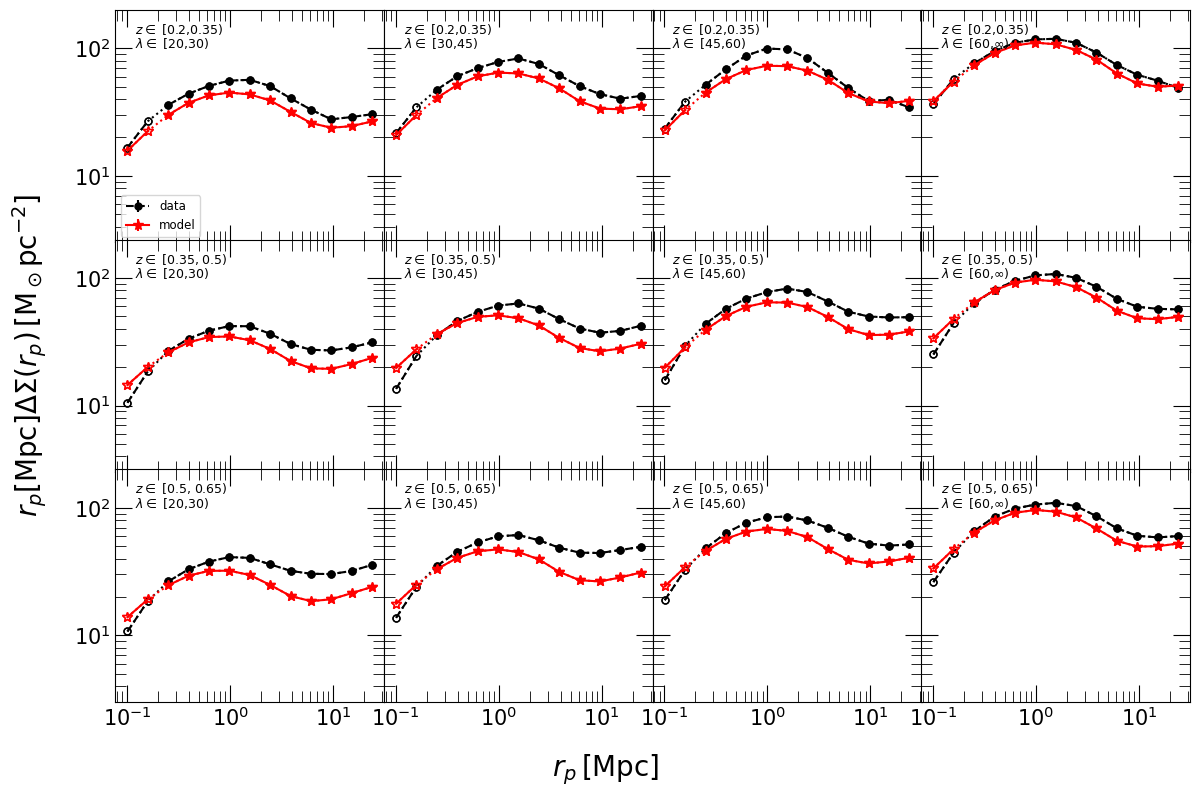

In [7]:
# Create a figure and four subplots (3 rows, 4 columns)
cov = np.identity(len(rp))
cc = []
sel = (rp > 0.10)&(rp < 999)
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharey=True, sharex = True)
# files_list = []
for i in range(3):
    for j in range(4):
        if i == 0:
            k = j
        if i == 1:
            k = j+4
        if i == 2:
            k = j+8
        # print(k)
        
        z = halos_ds["Redshift"][k]
        a = 1/(1+z)
        # rp_phys = rp*1e3#*a #physical kpc/h
        log10_M = halos_ds["Mvir"][k]
        M=(10**log10_M)/h
        ds = halos_ds["DS_mean"][k]#/(1e12*h)
        # ds = halos_ds["DS_mean"][i][sel]*1e-12

        c = halos_ds["cvir"][k]
        # c = concentration.concentration(M=M, mdef='vir', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
        cc.append(c)
        args = [log10_M, c]
        _, ds_theory_ctk, ds_theory_nfw, ds_theory_einasto = log_likelihood(params = args, rp = rp, 
                                                                            data = ds, cov = cov, 
                                                                            z = z, input_units = "physical")

        # print(ds)
        # print(ave_DS, "\n")
        inds1 = (rp >= 0.20)*(rp < 999) 
        inds2 = (rp >= 0.1)*(rp < 0.2) 
        inds3 = (rp >= 0.10)*(rp < 999) 
        # inds = rp > 0.0
        rp1 = rp[inds1]
        rp2 = rp[inds2]
        rp3 = rp[inds3]

######################################################################
######################################################################
        ########################
        axes[i, j].loglog()
        axes[i, j].set_ylim(0.3e1, 2e2)
        axes[i, j].text(0.120, 130.0, f"$z \in$ {halos_ds['redshift_range'][k]}", fontsize = 9)
        axes[i, j].text(0.120, 100.0, f"$\lambda \in$ {halos_ds['lambda_range'][k]}", fontsize = 9)
        axes[i, j].errorbar(rp1, rp1*ds[inds1], yerr = np.zeros(len(rp1)), fmt = '--o', ms = 5.0, color = 'black', label='data')
        axes[i, j].errorbar(rp2, rp2*ds[inds2], yerr = np.zeros(len(rp2)), fmt = '--o', ms = 5.0, color = 'black', fillstyle='none')
        axes[i, j].errorbar(rp3, rp3*ds[inds3], yerr = np.zeros(len(rp3)), fmt = ':o', ms = 5.0, color = 'black', fillstyle='none')
        
        axes[i, j].errorbar(rp1, rp1*ds_theory_ctk[inds1], yerr = np.zeros(len(rp1)), fmt = '-*', ms = 7.0, color = 'red', label='model')
        axes[i, j].errorbar(rp2, rp2*ds_theory_ctk[inds2], yerr = np.zeros(len(rp2)), fmt = '-*', ms = 7.0, color = 'red', fillstyle='none')
        axes[i, j].errorbar(rp3, rp3*ds_theory_ctk[inds3], yerr = np.zeros(len(rp3)), fmt = ':*', ms = 7.0, color = 'red', fillstyle='none')
        # axes[i, j].plot(rp[sel], rp[sel]*ds_theory_nfw[sel], ls='-', c='k', label='colossus nfw')
        # axes[i, j].plot(rp[sel], rp[sel]*ds_theory_einasto[sel], ls='-.', c='r', label='colossus einasto')
        if i == 0 and j == 0:
            axes[i, j].legend(fontsize=8.5, loc = "lower left")
        else:
            pass
        
# Add a super title, super x label, and super y label
# fig.suptitle(r'$\Delta\Sigma$ Profiles', fontsize=20)
fig.supxlabel(r"$\rm \mathit{r_p}\,[\mathrm{Mpc}]$", fontsize=20)
fig.supylabel(r"$\rm \mathit{r_p}[\mathrm{Mpc}] \Delta\Sigma(\mathit{r_p})\,[M_\odot \mathrm{pc}^{-2}]$", x = 0.02, y = 0.55, va='center', ha='center', fontsize=20)


# Adjust spacing between subplots
plt.tight_layout(h_pad = -0.20, w_pad = -1.150)
plt.show()
######################################################################
######################################################################    

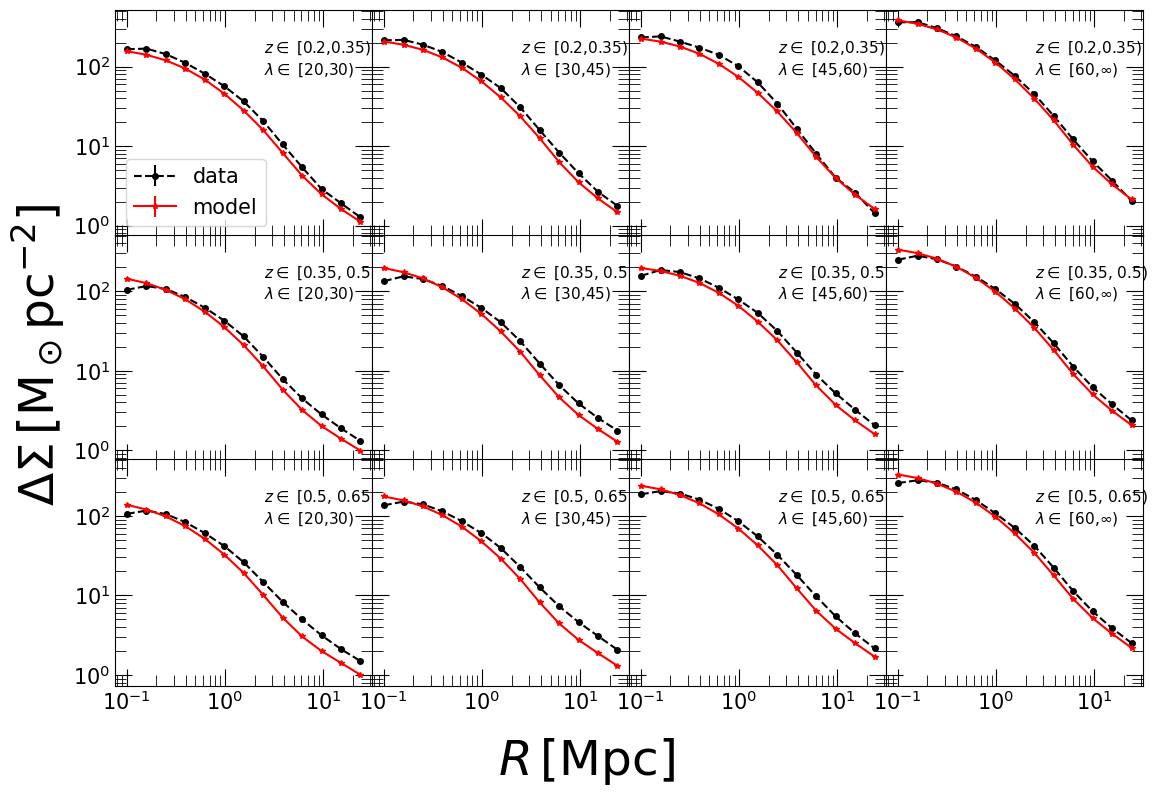

In [8]:
# Create a figure and four subplots (3 rows, 4 columns)
# sel = rp > 0.10
sel = (rp > 0.10)&(rp < 999)
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharey=True, sharex = True)
# files_list = []
for i in range(3):
    for j in range(4):
        if i == 0:
            k = j
        if i == 1:
            k = j+4
        if i == 2:
            k = j+8
        # print(k)
        
        z = halos_ds["Redshift"][k]
        a = 1/(1+z)
        # rp_phys = rp*1e3#*a #physical kpc/h
        log10_M = halos_ds["Mvir"][k]
        M=(10**log10_M)/h
        ds = halos_ds["DS_mean"][k]#/(1e12*h)
        # ds = halos_ds["DS_mean"][i][sel]*1e-12

        c = halos_ds["cvir"][k]
        # c = concentration.concentration(M=M, mdef='vir', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
        cc.append(c)
        args = [log10_M, c]
        _, ds_theory_ctk, ds_theory_nfw, ds_theory_einasto = log_likelihood(params = args, rp = rp, 
                                                                            data = ds, cov = cov, 
                                                                            z = z, input_units = "physical")


######################################################################
######################################################################
        ########################
        axes[i, j].loglog()
        # axes[i, j].set_ylim(0.3e1, 2e2)
        axes[i, j].text(2.50, 150.0, f"$z \in$ {halos_ds['redshift_range'][k]}", fontsize = 11)
        axes[i, j].text(2.50, 80.0, f"$\lambda \in$ {halos_ds['lambda_range'][k]}", fontsize = 11)
        axes[i, j].errorbar(rp[sel], ds[sel], yerr = np.zeros(len(rp[sel])), fmt = '--o', ms = 4.0, color = 'black', label='data')
        axes[i, j].errorbar(rp[sel], ds_theory_ctk[sel], yerr = np.zeros(len(rp[sel])), fmt = '-*', ms = 4.0, color = 'red', label='model')
        # axes[i, j].plot(rp[sel], rp[sel]*ds_theory_nfw[sel], ls='-', c='k', label='colossus nfw')
        # axes[i, j].plot(rp[sel], rp[sel]*ds_theory_einasto[sel], ls='-.', c='r', label='colossus einasto')
        if i == 0 and j == 0:
            axes[i, j].legend(fontsize=15, loc = "lower left")
        else:
            pass
        
# Add a super title, super x label, and super y label
# fig.suptitle(r'$\Delta\Sigma$ Profiles', fontsize=20)
fig.supxlabel(r"$\rm \mathit{R}\,[\mathrm{Mpc}]$", fontsize=35)
fig.supylabel(r"$\rm \Delta\Sigma\,[M_\odot \mathrm{pc}^{-2}]$", x = 0.02, y = 0.55, va='center', fontsize=35)

# Adjust spacing between subplots
plt.tight_layout(h_pad = -0.50, w_pad = -3.10)
plt.show()
######################################################################
######################################################################    

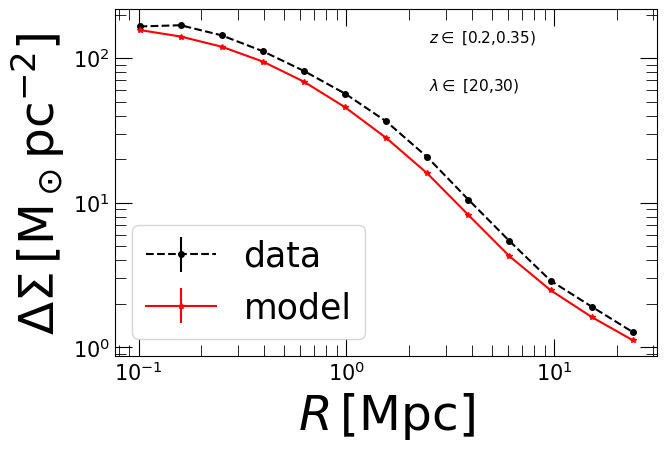

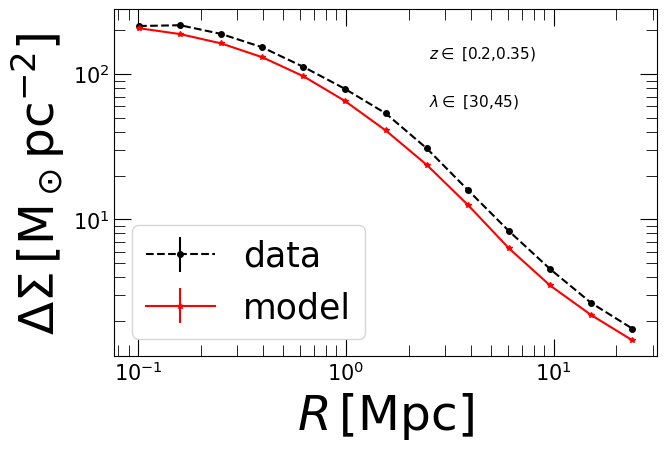

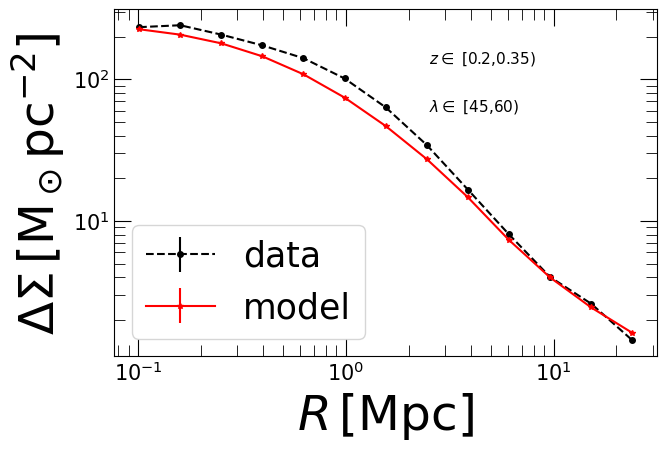

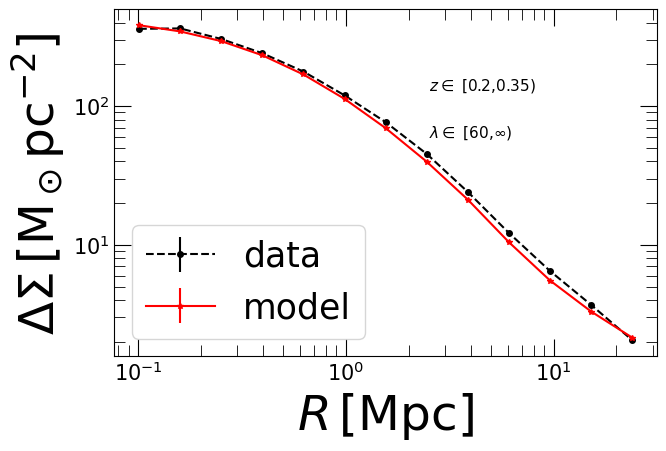

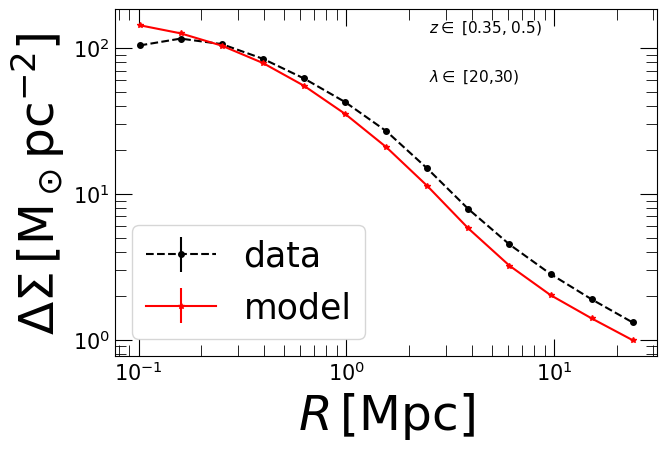

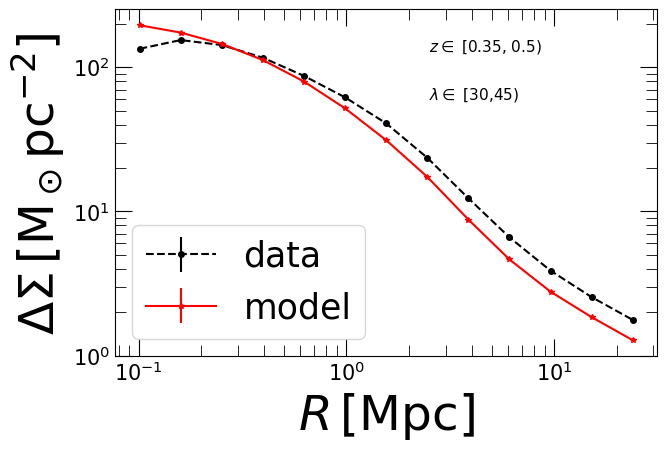

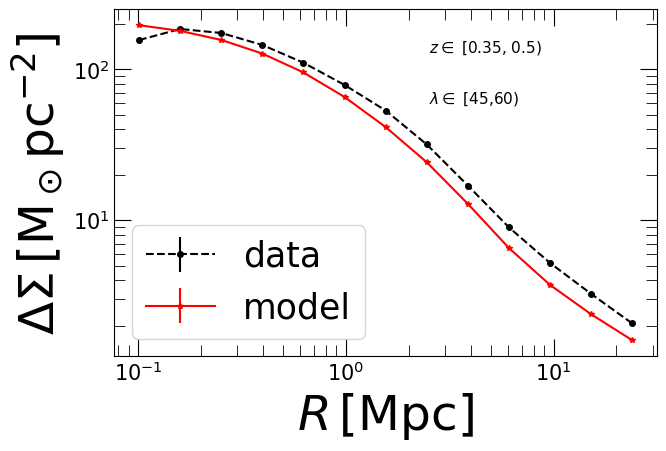

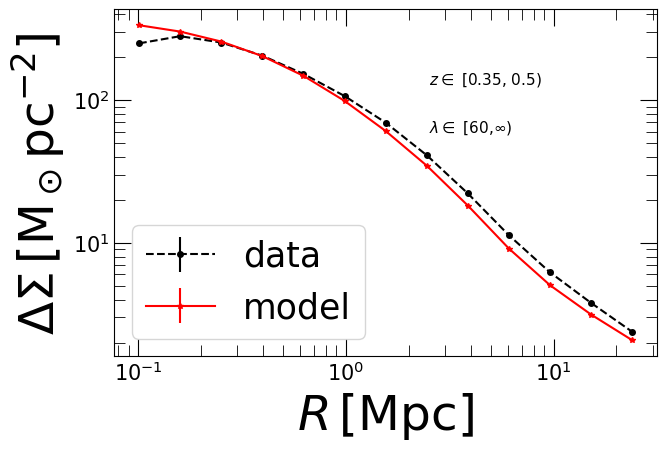

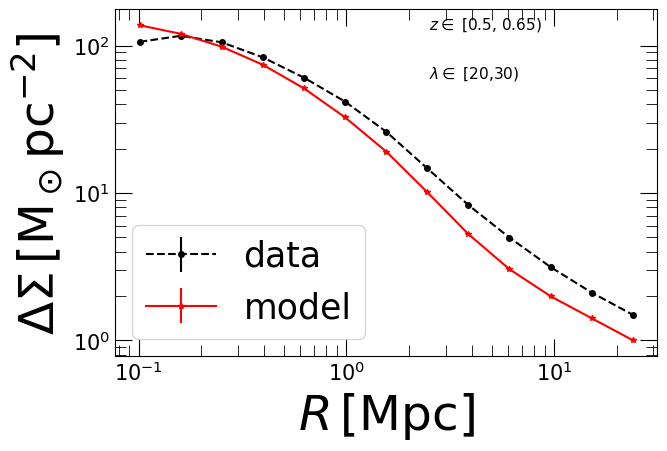

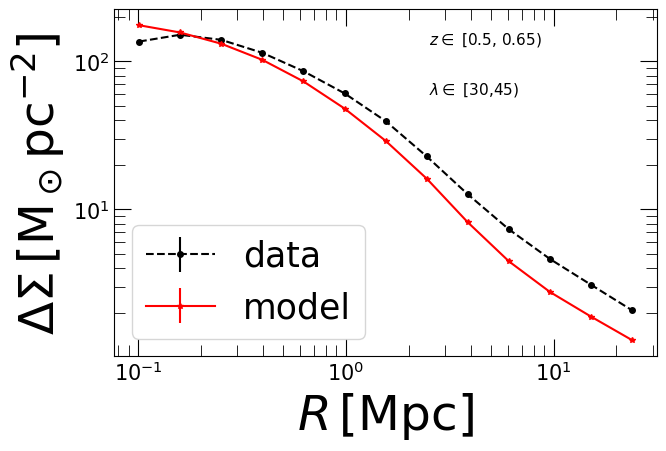

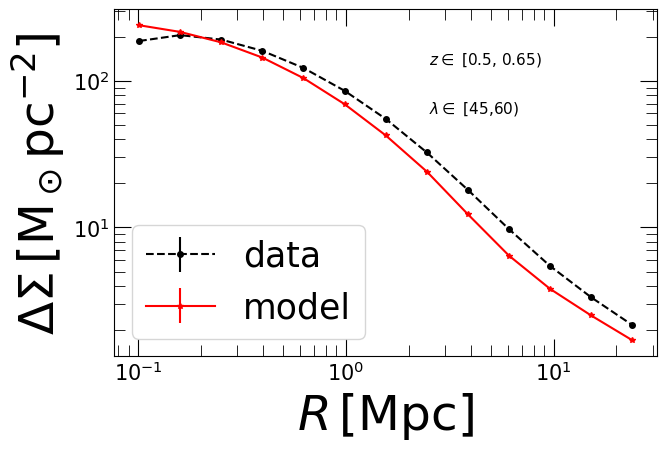

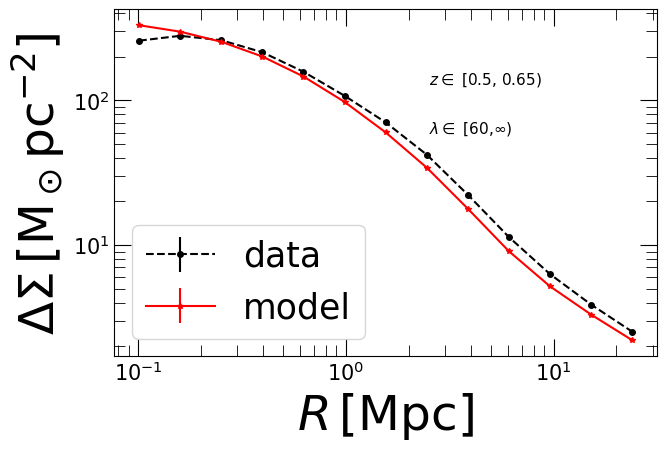

In [9]:
# Create a figure and four subplots (3 rows, 4 columns)
# sel = rp > 0.10
sel = (rp >= 0.10)&(rp < 999)
sel2 = (rp >= 0.0)&(rp < 0.2)
# fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharey=True, sharex = True)
# files_list = []
for i in range(3):
    for j in range(4):
        if i == 0:
            k = j
        if i == 1:
            k = j+4
        if i == 2:
            k = j+8
        # print(k)
        
        z = halos_ds["Redshift"][k]
        a = 1/(1+z)
        # rp_phys = rp*1e3#*a #physical kpc/h
        log10_M = halos_ds["Mvir"][k]
        M=(10**log10_M)/h
        ds = halos_ds["DS_mean"][k]#/(1e12*h)
        # ds = halos_ds["DS_mean"][i][sel]*1e-12

        c = halos_ds["cvir"][k]
        # c = concentration.concentration(M=M, mdef='vir', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
        cc.append(c)
        args = [log10_M, c]
        _, ds_theory_ctk, ds_theory_nfw, ds_theory_einasto = log_likelihood(params = args, rp = rp, 
                                                                            data = ds, cov = cov, 
                                                                            z = z, input_units = "physical")

        fig, axes = plt.subplots(1, 1, figsize=(7, 4.5), sharey=True, sharex = True)
######################################################################
######################################################################
        ########################
        axes.loglog()
        # axes[i, j].set_ylim(0.3e1, 2e2)
        axes.text(2.50, 130.0, f"$z \in$ {halos_ds['redshift_range'][k]}", fontsize = 11)
        axes.text(2.50, 60.0, f"$\lambda \in$ {halos_ds['lambda_range'][k]}", fontsize = 11)
        # axes.errorbar(rp[sel2], ds[sel2], yerr = np.zeros(len(rp[sel2])), fmt = '--o', ms = 4.0, color = 'black', fillstyle='none')
        axes.errorbar(rp[sel], ds[sel], yerr = np.zeros(len(rp[sel])), fmt = '--o', ms = 4.0, color = 'black', label='data')
        
        # axes.errorbar(rp[sel2], ds_theory_ctk[sel2], yerr = np.zeros(len(rp[sel2])), fmt = '-*', ms = 4.0, color = 'red', fillstyle='none')
        axes.errorbar(rp[sel], ds_theory_ctk[sel], yerr = np.zeros(len(rp[sel])), fmt = '-*', ms = 4.0, color = 'red', label='model')
        
        axes.set_xlabel(r"$\rm \mathit{R}\,[\mathrm{Mpc}]$", fontsize=35)
        axes.set_ylabel(r"$\rm \Delta\Sigma\,[M_\odot \mathrm{pc}^{-2}]$", fontsize=35)
        axes.legend(fontsize=25, loc = "lower left")
        plt.show()
        

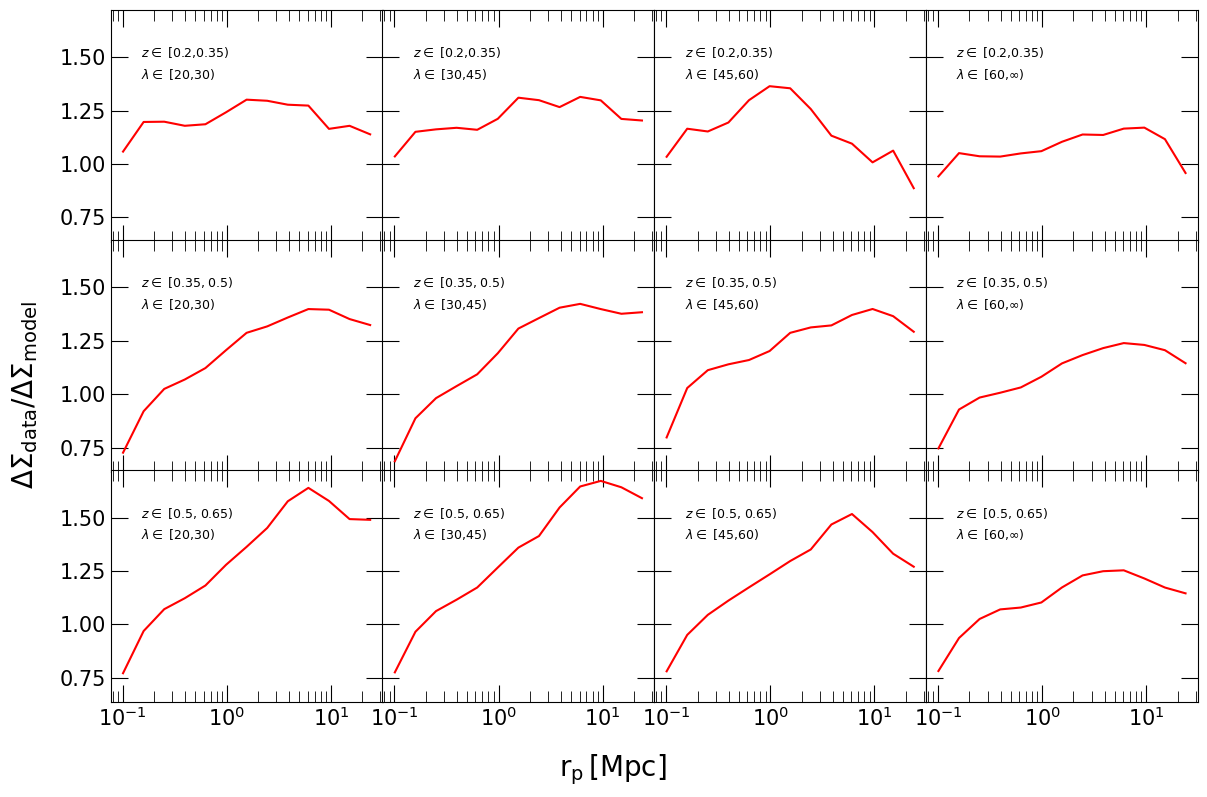

In [10]:
# Create a figure and four subplots (3 rows, 4 columns)
sel = rp > 0.10
# sel = (rp > 0.10)&(rp < 9)
fig, axes = plt.subplots(3, 4, figsize=(12, 8), sharey=True, sharex = True)
# files_list = []
for i in range(3):
    for j in range(4):
        if i == 0:
            k = j
        if i == 1:
            k = j+4
        if i == 2:
            k = j+8
        # print(k)
        
        z = halos_ds["Redshift"][k]
        a = 1/(1+z)
        # rp_phys = rp*1e3#*a #physical kpc/h
        log10_M = halos_ds["Mvir"][k]
        M=(10**log10_M)/h
        ds = halos_ds["DS_mean"][k]#/(1e12*h)
        # ds = halos_ds["DS_mean"][i][sel]*1e-12

        c = halos_ds["cvir"][k]
        # c = concentration.concentration(M=M, mdef='vir', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
        cc.append(c)
        args = [log10_M, c]
        _, ds_theory_ctk, ds_theory_nfw, ds_theory_einasto = log_likelihood(params = args, rp = rp, 
                                                                            data = ds, cov = cov, 
                                                                            z = z, input_units = "physical")

######################################################################
######################################################################
        ########################
        # axes[i, j].loglog()
        axes[i, j].set_xscale("log")
        # axes[i, j].set_ylim(0.0, 1.5)
        axes[i, j].text(0.150, 1.50, f"$z \in$ {halos_ds['redshift_range'][k]}", fontsize = 9)
        axes[i, j].text(0.150, 1.40, f"$\lambda \in$ {halos_ds['lambda_range'][k]}", fontsize = 9)
        axes[i, j].plot(rp[sel], ds[sel]/ds_theory_ctk[sel], ls='-', c='r', label='data/cluster toolkit')
        # axes[i, j].legend(fontsize=9, loc = "lower center")
        
# Add a super title, super x label, and super y label
# fig.suptitle(r'Ratio of data and model', fontsize=20)
fig.supxlabel(r"$\rm r_p\,[\mathrm{Mpc}]$", fontsize=20)
fig.supylabel(r"$\rm \Delta\Sigma_{data}/\Delta\Sigma_{model}$", x = 0.01, y = 0.5, va='center', ha='center', fontsize=20)

# Adjust spacing between subplots
plt.tight_layout(h_pad = -0.1, w_pad = -1.120)
plt.show()